# Lamprey Transcriptome Analysis: Gene Model Overlap Notebook

```
Camille Scott [camille dot scott dot w @gmail.com] [@camille_codon]

camillescott.github.io

Lab for Genomics, Evolution, and Development
Michigan State University
```

## About

Explores consensus between assembled transcripts and existing lamprey gene models, using the `gtf_to_genes` library.

    assembly version: lamp10

    assembly program: Trinity
    
    gtf model versin: 7.0.75
    
There is another script in this directory called `petmar-gtf-overlap.py` which loads the database and does the `apply` function to query overlaps for each hit, as those operations take a very long time (these are a definite target for optimization).

In [103]:
!echo $PWD

/work/2015-petMarSB/notebooks


## Contents

1. [Libraries](#Libraries) 
* [Data Loading](#Data-Loading)
* [Matplotlib RC Settings](#Matplotlib-RC-Settings)
* [Existing Gene Models](#Existing-Gene-Models)
     1. [Interval Query Initialization](#Interval-Query-Initialization)
     * [Utility Functions](#Utility-Functions)
     * [Results](#Results)

## Libraries

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
%autosave 60

Autosaving every 60 seconds


In [106]:
from libs import *
%run -i common.ipy

** Using data resources found in ../resources.json
** Using config found in ../config.json


In [107]:
from joshua.intervaltree import Interval, IntervalTree
from joshua.intervalforest import IntervalForest

In [108]:
from joshua import utils as ju

In [109]:
from IPython.html.widgets import interactive, RadioButtonsWidget
from IPython.display import display
from IPython.html import widgets

In [110]:
import pyprind

In [111]:
from gtftools import read_gtf

In [112]:
from blasttools import blast_to_df
import intervaltools as ivt

## Matplotlib RC Settings

In [113]:
%pylab inline
from matplotlib import rc_context
tall_size = (8,16)
norm_size = (12,8)
mpl_params = {'figure.autolayout': True,
               'axes.titlesize': 24,
               'axes.labelsize': 16,
               'ytick.labelsize': 14,
               'xtick.labelsize': 14
               }
sns.set(style="white", palette="Paired", rc=mpl_params)
#sns.set_palette("Paired", desat=.6)
b, g, r, p = sns.color_palette("muted", 4)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [114]:
%config InlineBackend.close_figures = False

For results that we want to end up in the paper; we will dump it to JSON and use it to render our jinja templated tex file.

In [115]:
results = {}

In [116]:
resources_df[resources_df.meta_type == 'fasta_database']

,access,condition,db_type,filename,flowcell,label,meta_type,paired,phred,q_type,strand,terms,tissue,url,size
Myxinidae_pep,remote_query,NaN,prot,Myx.pep.all.fa,NaN,NaN,fasta_database,NaN,NaN,uniprot,NaN,taxonomy:7762,NaN,NaN,1004
braFlo_pep,remote_query,NaN,prot,braFlo.pep.all.fa,NaN,NaN,fasta_database,NaN,NaN,uniprot,NaN,organism:7739+AND+keyword:1185,NaN,NaN,28544
danRer_pep,remote_file,NaN,prot,danRer.pep.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-75/fasta/dan...,43153
homSap_pep,remote_file,NaN,prot,homSap.pep.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-74/fasta/hom...,104763
musMus_pep,remote_file,NaN,prot,musMus.pep.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-75/fasta/mus...,52165
petMar2,remote_file,NaN,nucl,petMar2.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-75/fasta/pet...,25006
petMar2_cdna,remote_file,NaN,nucl,petMar2.cdna.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-75/fasta/pet...,11489
petMar2_cds,remote_file,NaN,nucl,petMar2.cds.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-75/fasta/pet...,11442
petMar2_ncrna,remote_file,NaN,nucl,petMar2.ncrna.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-75/fasta/pet...,2652
petMar2_pep,remote_file,NaN,prot,petMar2.pep.fa,NaN,NaN,fasta_database,NaN,NaN,NaN,NaN,NaN,NaN,ftp://ftp.ensembl.org/pub/release-75/fasta/pet...,11442


## Data Loading

In [117]:
store = pd.HDFStore(wdir('{}.store.h5'.format(prefix)), complib='zlib', complevel=5)

In [118]:
import atexit

In [119]:
def dump_results(fn='../doc/petmar-cross-validate.results.json'):
    with open(fn, 'wb') as fp:
        json.dump(results, fp)

In [120]:
def exit_func():
    dump_results()
    store.close()
atexit.register(exit_func)

<function __main__.exit_func>

In [121]:
lamp10_db = screed.ScreedDB(wdir(resources_df.filename['lamp10']))
lamp00_db = screed.ScreedDB(wdir(resources_df.filename['petMar2_cdna']))
petMar2_db = screed.ScreedDB(wdir(resources_df.filename['petMar2']))

In [122]:
lamp00_pM_df = store['petMar2.cdna.fa.x.petMar2.fa.db.tsv']
lamp00_pM_df.reset_index('qseqid', inplace=True)
lamp00_pM_df.index.set_names('aln_id', inplace=True)
lamp00_pM_df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,sstrand,qstrand
aln_id,,,,,,,,,,,,,,
0,ENSPMAT00000006216,GL483616,100.00,200,0,0,0,200,8282,8482,1.000000e-100,370,-1,1
1,ENSPMAT00000006216,GL483616,100.00,132,0,0,393,525,1076,1208,8.000000e-63,244,-1,1
2,ENSPMAT00000006216,GL483616,99.16,119,0,1,197,315,5552,5671,2.000000e-53,213,-1,1
3,ENSPMAT00000006216,GL483616,100.00,82,0,0,311,393,1755,1837,5.000000e-35,152,-1,1
4,ENSPMAT00000006212,GL476841,100.00,456,0,0,366,822,228301,228757,0.000000e+00,843,-1,1


In [123]:
lamp10_pM_df = store['lamp10.fasta.x.petMar2.fa.db.tsv']
lamp10_pM_df.reset_index('qseqid', inplace=True)
lamp10_pM_df.index.set_names('aln_id', inplace=True)
lamp10_pM_df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,sstrand,qstrand
aln_id,,,,,,,,,,,,,,
0,c534414_g1_i1,GL477458,99.44,179,1,0,14,193,59695,59874,1.000000e-87,326,-1,1
1,c534508_g1_i1,GL487923,100.00,214,0,0,0,214,7825,8039,8.000000e-109,396,-1,1
2,c534069_g1_i1,GL476614,99.52,210,1,0,0,210,444049,444259,7.000000e-105,383,1,1
3,c534741_g1_i1,GL482427,99.51,203,1,0,0,203,5542,5745,5.000000e-101,370,-1,1
4,c534445_g1_i1,GL478305,99.58,239,1,0,0,239,15029,15268,6.000000e-121,436,-1,1


In [124]:
if not 'gtf_df' in store:
    gtf_file = wdir(resources_df.ix['petMar2_gtf'].filename)
    gtf_df = read_gtf(gtf_file)
    gtf_df.sort(columns=['contig_id'], inplace=True)
    gtf_df.index.set_names('ann_id', inplace=True)
    gtf_df['feature_length'] = gtf_df.end - gtf_df.start
    store['gtf_df'] = gtf_df
else:
    gtf_df = store['gtf_df']
gtf_df.head()

,contig_id,source,feature,start,end,score,strand,frame,exon_id,exon_number,gene_biotype,gene_id,gene_name,gene_source,protein_id,transcript_id,transcript_name,transcript_source,feature_length
ann_id,,,,,,,,,,,,,,,,,,,
5124,GL476328,protein_coding,gene,168846,169476,.,1,.,NaN,NaN,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,NaN,NaN,NaN,NaN,630
5125,GL476328,protein_coding,transcript,168846,169476,.,1,.,NaN,NaN,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,NaN,ENSPMAT00000011401,cdkn1c-201,ensembl,630
5126,GL476328,protein_coding,exon,168846,169476,.,1,.,ENSPMAE00000096602,1,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,NaN,ENSPMAT00000011401,cdkn1c-201,ensembl,630
5127,GL476328,protein_coding,CDS,168846,169476,.,1,0,NaN,1,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,ENSPMAP00000011355,ENSPMAT00000011401,cdkn1c-201,ensembl,630
5128,GL476328,protein_coding,gene,235293,235778,.,-1,.,NaN,NaN,protein_coding,ENSPMAG00000007839,rps4x,ensembl,NaN,NaN,NaN,NaN,485


In [125]:
lamp10_tpm_df = store['lamp10.eXpress.tpm.tsv']

In [126]:
lamp10_best_hits = store['lamp10_best_hits']
lamp10_blast_filter_df = store['lamp10_blast_filter_df']

In [187]:
lamp10_ortho = store['lamp10_ortho']

## Repetitive Sequence

Approximately 34.7% of the sea lamprey genome comprises repetitive elements. How much of our assembly has significant alignment with these repetitive regions?

In [333]:
def check_rep(row):
    aln_seq = petMar2_db[row.sseqid].sequence[row.sstart:row.send]
    num_repetitive = sum([c.islower() for c in aln_seq])
    return num_repetitive

In [334]:
reps = lamp10_pM_df.apply(check_rep, axis=1)

In [336]:
lamp10_pM_df['rep_bases'] = reps

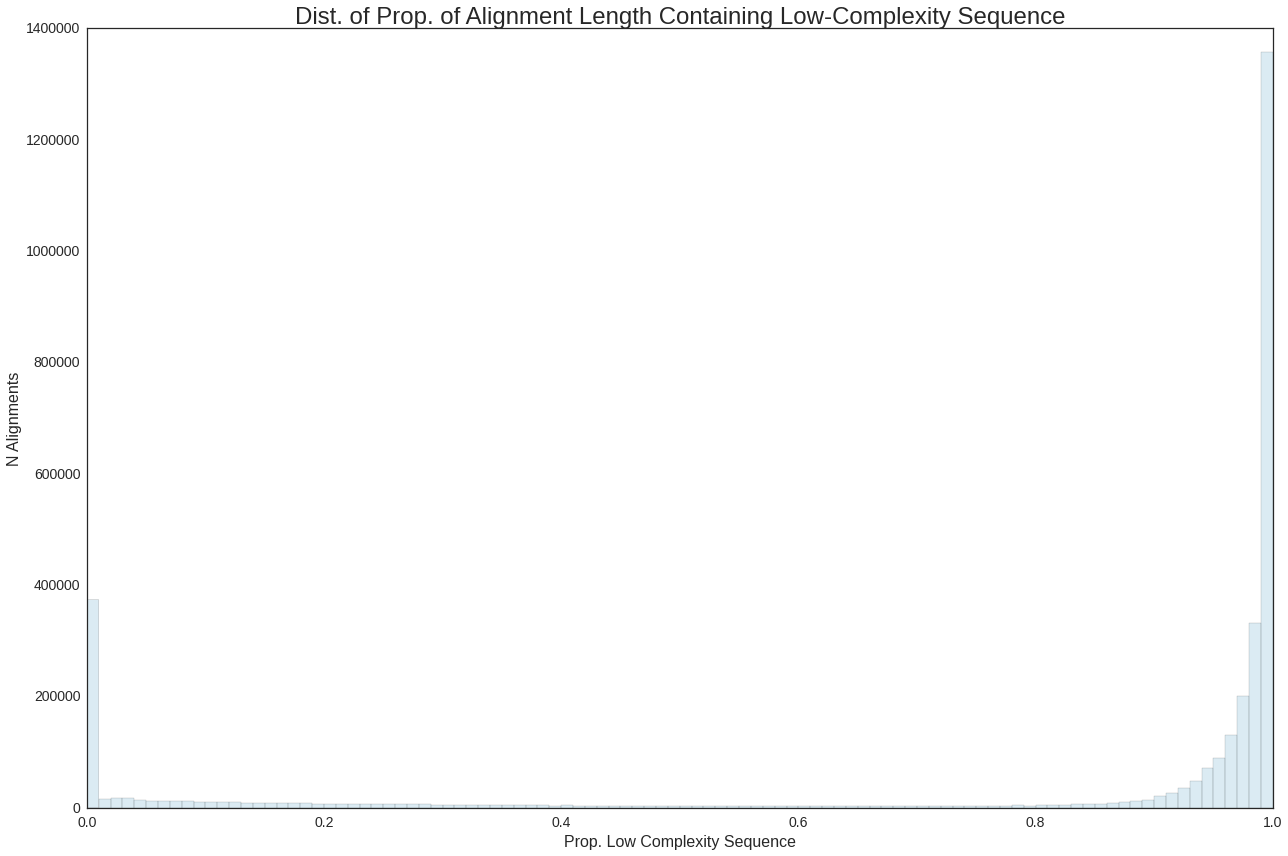

In [376]:
with FigManager() as (fig, ax):
    sns.distplot(lamp10_pM_df.rep_bases / lamp10_pM_df.length, kde=False, ax=ax, bins=100)
    ax.set_title('Dist. of Prop. of Alignment Length Containing Low-Complexity Sequence')
    ax.set_xlabel('Prop. Low Complexity Sequence')
    ax.set_ylabel('N Alignments')

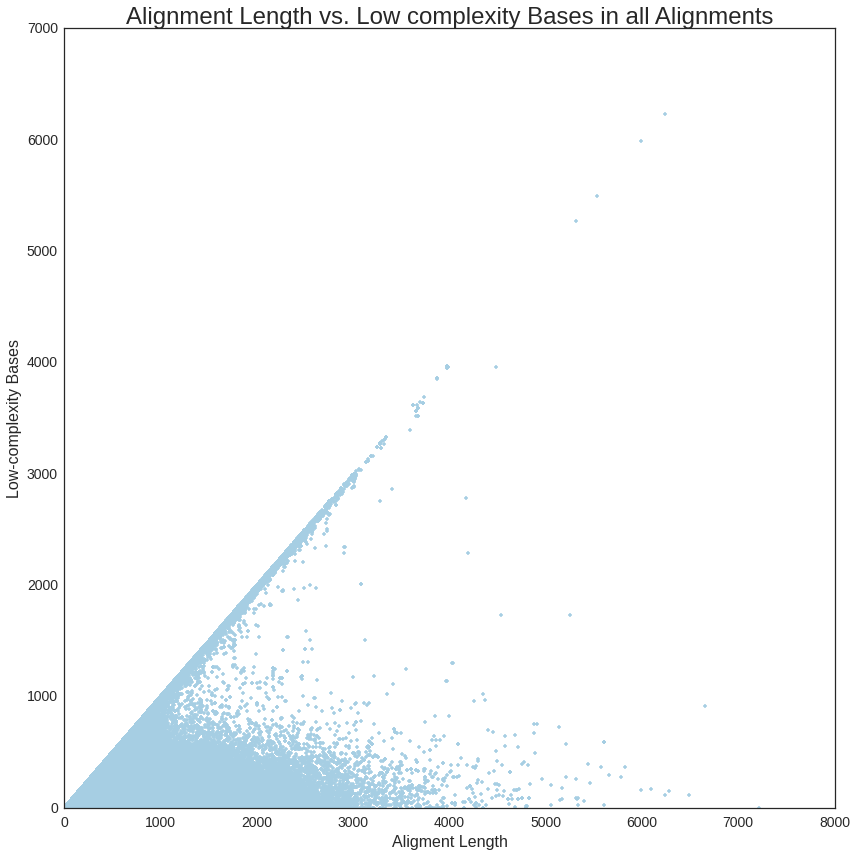

In [373]:
with FigManager(figsize=(12,12)) as (fig, ax):
    ax.plot(lamp10_pM_df.length, lamp10_pM_df.rep_bases, '.')
    ax.set_ylabel('Low-complexity Bases')
    ax.set_xlabel('Aligment Length')
    ax.set_title('Alignment Length vs. Low complexity Bases in all Alignments')

In [ ]:
with FigManager(figsize=(12,12)) as (fig, ax):
    ax.plot(lamp10_pM_df.length, lamp10_pM_df.rep_bases, '.')
    ax.set_ylabel('Low-complexity Bases')
    ax.set_xlabel('Aligment Length')
    ax.set_title('Alignment Length vs. Low complexity Bases in all Alignments')

In [370]:
def query_rep(group):
    return float(group.rep_bases.sum()) / group.length.sum()

In [371]:
q_rep = lamp10_pM_df.groupby('qseqid').apply(query_rep)

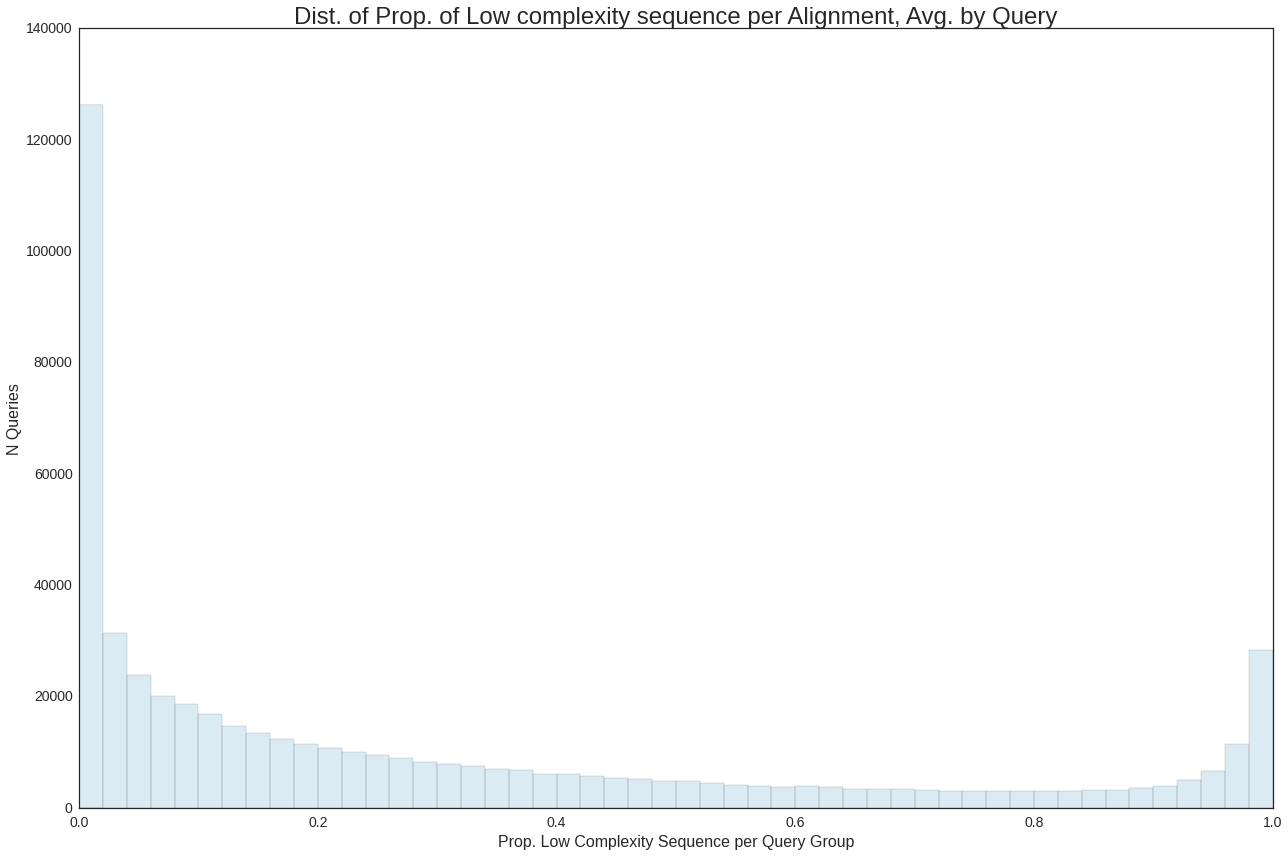

In [374]:
with FigManager() as (fix, ax):
    sns.distplot(q_rep, kde=False, ax=ax)
    ax.set_title('Dist. of Prop. of Low complexity sequence per Alignment, Avg. by Query')
    ax.set_xlabel('Prop. Low Complexity Sequence per Query Group')
    ax.set_ylabel('N Queries')

In [379]:
lamp10_lowcomp_filter = (lamp10_pM_df.rep_bases / lamp10_pM_df.length) > 0.9

In [384]:
float(lamp10_lowcomp_filter.sum()) / len(lamp10_lowcomp_filter)

0.7167431064689275

## Gene Models from Pmarinus 7.0.75

In [127]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [128]:
%%cython
cimport numpy as np
import numpy as np

from joshua.intervaltree import Interval, IntervalTree
from joshua.intervalforest import IntervalForest

from intervaltools import DataFrameInterval

cpdef list build_intervals(np.ndarray[long] idxs, np.ndarray[long] starts, np.ndarray[long] ends, \
                           np.ndarray chroms, np.ndarray[long] strands, object df):
    cdef list intervals = []
    cdef int i = 0
    cdef object iv

    for i in range(len(starts)):
        #print type(starts[i])
        #print type(ends[i])
        #print type(strands[i])
        iv = DataFrameInterval(idxs[i], df, starts[i], ends[i], chrom=str(chroms[i]), strand=strands[i])
        intervals.append(iv)
    return intervals

def build_forest_from_groups(grouped_df, reference_df, start_col, end_col, chrom_col, strand_col, bar=None):

    forest = IntervalForest()
    
    for key, group in grouped_df:
        tree = IntervalTree()
        intervals = build_intervals(group.index.values, group[start_col].values, group[end_col].values,
                                    group[chrom_col].values, group[strand_col].values, reference_df)
        for iv in intervals:
            tree.insert_interval(iv)
            if bar is not None:
                bar.update()
        forest.add_tree(key, tree)

    return forest

### Build Interval Trees

Build an IntervalTree of BLAST alignments to each contig

In [129]:
bar = pyprind.ProgBar(len(lamp10_pM_df), stream=1, title='Build BLAST interval forest')
lamp10_aln_subj_forest = build_forest_from_groups(lamp10_pM_df.groupby('sseqid'), lamp10_pM_df,
                                       'sstart', 'send', 'sseqid', 'sstrand', bar=bar)

Build BLAST interval forest
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 40.037 sec


Build an IntervalTree of GTF features for each contig

In [130]:
bar = pyprind.ProgBar(len(gtf_df), stream=1, title='Build GTF interval forest')
petmar_gtf_forest = build_forest_from_groups(gtf_df.groupby('contig_id'), gtf_df,
                                       'start', 'end', 'contig_id', 'strand', bar=bar)

Build GTF interval forest
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 3.433 sec


Do the same for lamp00.

In [131]:
bar = pyprind.ProgBar(len(lamp00_pM_df), stream=1, title='Build BLAST interval trees')
lamp00_aln_subj_forest = build_forest_from_groups(lamp00_pM_df.groupby('sseqid'), lamp00_pM_df,
                                       'sstart', 'send', 'sseqid', 'sstrand', bar=bar)

Build BLAST interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 14.768 sec


In [132]:
def calc_tree_area(tree, filter_fn=lambda iv: iv.value.feature in ['UTR', 'exon', 'CDS', 'start_codon', 'stop_codon']):
    
    intervals = [iv for _, _, iv in tree if filter_fn(iv)]
    intervals.sort(key = lambda iv: iv.start)
    merged = ju.merge_overlapping_sorted(intervals)
    
    return sum(len(iv) for iv in merged)

In [133]:
area_results = []
for key, tree in petmar_gtf_forest:
    area = calc_tree_area(tree)
    total = len(petMar2_db[key].sequence)
    area_results.append({'contig_id': key, 'covered': area, 'length': total, 'prop': float(area) / total})

In [134]:
petmar_gtf_area_df = pd.DataFrame(area_results)

In [135]:
area_results = []
for key, tree in lamp10_aln_subj_forest:
    area = calc_tree_area(tree, filter_fn=lambda iv: True)
    total = len(petMar2_db[key].sequence)
    area_results.append({'contig_id': key, 'covered': area, 'length': total, 'prop': float(area) / total})

In [136]:
lamp10_subj_area_df = pd.DataFrame(area_results)

In [137]:
genome_length = 0
for record in screed.open(wdir(resources_df.loc['petMar2'].filename)):
    genome_length += len(record.sequence)

In [138]:
float(petmar_gtf_area_df.length.sum()) / (genome_length / .8)

0.551223692312916

In [139]:
float(lamp10_subj_area_df.length.sum()) / (genome_length / .8)

0.7901382948986658

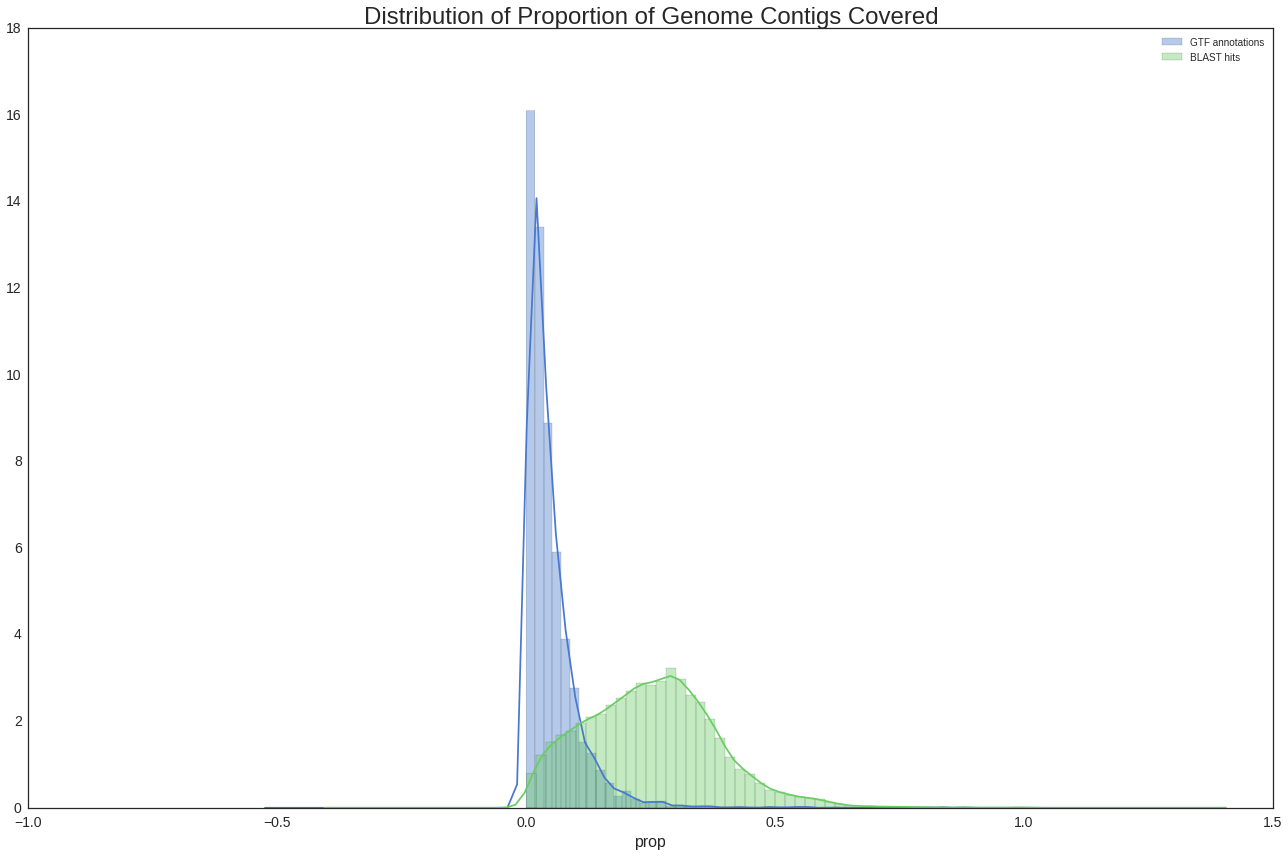

In [140]:
with sns.color_palette('muted'), FigManager() as (fix, ax):
    sns.distplot(petmar_gtf_area_df.prop, ax=ax, label='GTF annotations')
    sns.distplot(lamp10_subj_area_df.prop, ax=ax, label='BLAST hits')
    ax.legend()
    ax.set_title('Distribution of Proportion of Genome Contigs Covered')

### Sanity Check

In [141]:
petmar_gtf_self_df = pd.DataFrame(petmar_gtf_forest.intersect(petmar_gtf_forest), columns=['A', 'B', 'ov_len'])

In [142]:
(petmar_gtf_self_df.A == petmar_gtf_self_df.B).sum()

245163

In [143]:
(petmar_gtf_self_df.A == petmar_gtf_self_df.B).sum() == len(gtf_df)

True

### Calculate Overlap Data

#### Annotation x Alignment (lamp10)

In [161]:
ann_aln_ov_df = pd.DataFrame(petmar_gtf_forest.intersect(lamp10_aln_subj_forest, other_cutoff=0.0), 
                             columns=['ann_id', 'aln_id', 'ov_len'])
ann_aln_ov_df.sort(columns='ann_id', inplace=True)

In [162]:
ann_aln_ov_df.head()

,ann_id,aln_id,ov_len
464786,3,1556464,323
464787,4,1556464,323
464788,7,1556468,193
464789,7,1556470,193
464791,8,1556470,193


In [163]:
store['lamp10_ann_aln_ov_df'] = ann_aln_ov_df

#### Alignment x Annotation (lamp10)

In [164]:
aln_ann_ov_df = pd.DataFrame(lamp10_aln_subj_forest.intersect(petmar_gtf_forest, other_cutoff=0.0), 
                             columns=['aln_id', 'ann_id', 'ov_len'])
aln_ann_ov_df.sort(columns='aln_id', inplace=True)

In [165]:
aln_ann_ov_df.head()

,aln_id,ann_id,ov_len
26552,0,136550,179
26553,0,136551,179
1197474,2,10980,210
1197475,2,10981,210
102113,3,218614,203


In [166]:
store['lamp10_aln_ann_ov_df'] = aln_ann_ov_df

#### Annotation x Alignment (lamp00)

In [167]:
lamp00_ann_aln_ov_df = pd.DataFrame(petmar_gtf_forest.intersect(lamp00_aln_subj_forest, other_cutoff=0.0), 
                             columns=['ann_id', 'aln_id', 'ov_len'])
lamp00_ann_aln_ov_df.sort(columns='ann_id', inplace=True)

#### Alignment x Annotation (lamp00)

In [168]:
lamp00_aln_ann_ov_df = pd.DataFrame(lamp00_aln_subj_forest.intersect(petmar_gtf_forest, other_cutoff=0.0), 
                             columns=['aln_id', 'ann_id', 'ov_len'])
lamp00_aln_ann_ov_df.sort(columns='aln_id', inplace=True)

### Quantify Overlaps

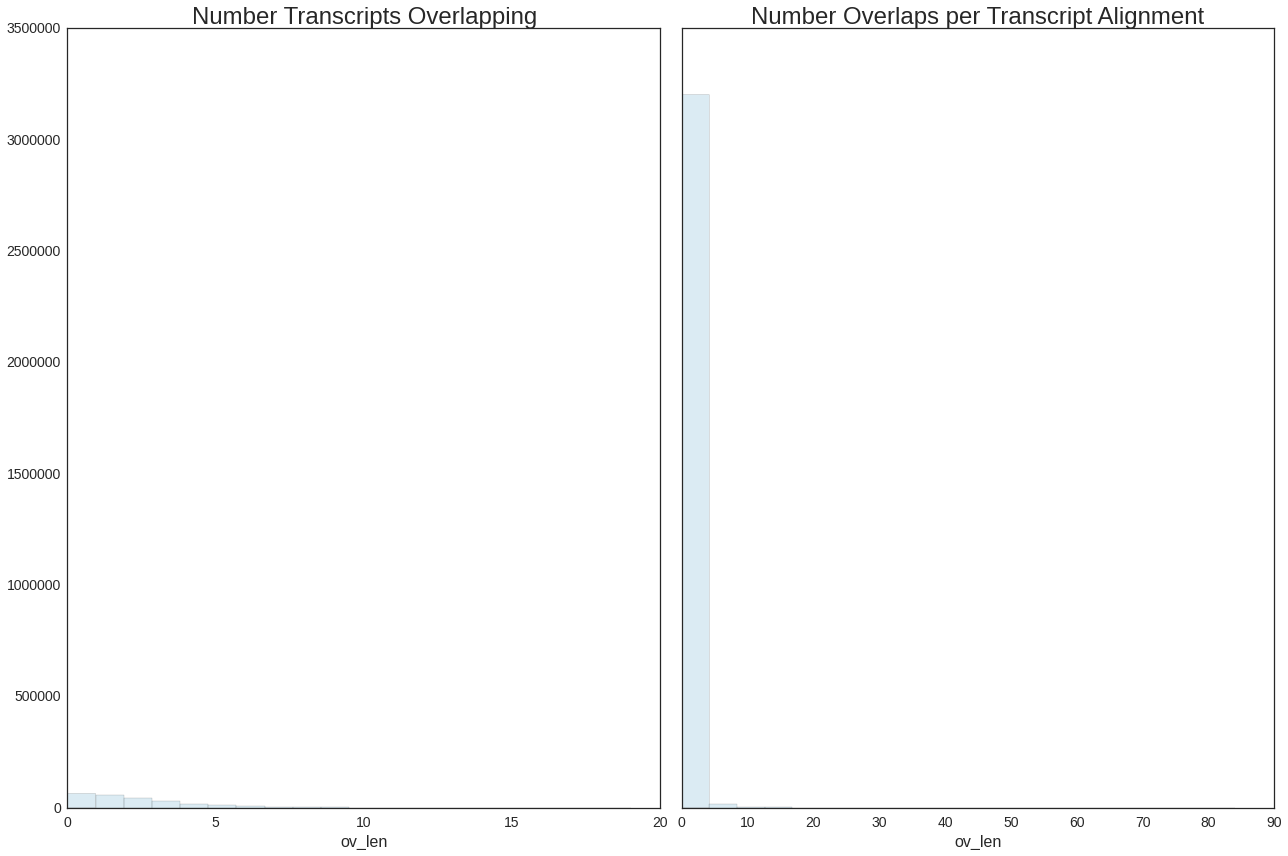

In [169]:
with FigManager(ncols=2, sharey=True) as (fix, ax):
    sns.distplot(pd.Series(ann_aln_ov_df.groupby('ann_id').count().ov_len, index=gtf_df.index).fillna(0), 
                 kde=False, bins=20, ax=ax[0])
    ax[0].set_title('Number Transcripts Overlapping')
    
    sns.distplot(pd.Series(aln_ann_ov_df.groupby('aln_id').count().ov_len, index=lamp10_pM_df.index).fillna(0), 
                 kde=False, bins=20, ax=ax[1])
    ax[1].set_title('Number Overlaps per Transcript Alignment')

Nothing suprising here -- most transcripts overlap 1 feature, and most features are overlapped by 1 transcript; there are many more transcripts than features.

#### Proportion of Annotations Overlapped

In [170]:
def calc_prop_ov():
    lamp00_prop = (float(len(lamp00_ann_aln_ov_df.groupby('ann_id'))) / len(gtf_df))
    lamp10_prop = (float(len(ann_aln_ov_df.groupby('ann_id'))) / len(gtf_df))
    
    return lamp00_prop, lamp10_prop

In [171]:
lamp00_prop, lamp10_prop = calc_prop_ov()
print 'lamp00:', lamp00_prop, '\nlamp10:', lamp10_prop, '\nratio:', lamp00_prop / lamp10_prop

lamp00: 0.80906172628 
lamp10: 0.739332607286 
ratio: 1.09431359892


In [172]:
results['lamp00_prop'] = lamp00_prop
results['lamp10_prop'] = lamp10_prop
results['lamp_prop_ratio'] = lamp00_prop / lamp10_prop

#### Proportion of Annotations Overlapped, by Feature

In [173]:
def calc_prop_ov_by_feature():
    lamp00_sums = (lamp00_ann_aln_ov_df.groupby('ann_id').count().ov_len != 0).groupby(gtf_df.feature).sum()
    lamp00_props = (lamp00_ann_aln_ov_df.groupby('ann_id').count().ov_len != 0).groupby(gtf_df.feature).sum() / \
                    gtf_df.groupby(gtf_df.feature).feature.count()
    
    lamp10_sums = (ann_aln_ov_df.groupby('ann_id').count().ov_len != 0).groupby(gtf_df.feature).sum()
    lamp10_props = (ann_aln_ov_df.groupby('ann_id').count().ov_len != 0).groupby(gtf_df.feature).sum() / \
                   gtf_df.groupby(gtf_df.feature).feature.count()
    
    return pd.DataFrame({'lamp00': lamp00_props, 'lamp10': lamp10_props}), \
           pd.DataFrame({'lamp00': lamp00_sums, 'lamp10': lamp10_sums})

In [174]:
feature_props, feature_sums = calc_prop_ov_by_feature()

In [175]:
feature_props

,lamp00,lamp10
feature,,
CDS,0.919196,0.814513
UTR,0.957400,0.862251
exon,0.896378,0.807120
gene,0.051323,0.147640
start_codon,0.960101,0.857505
stop_codon,0.636520,0.903922
transcript,0.048511,0.138392


The numbers look better when we break things down by feature. The `gene` and `transcript` features are course-grained (their intervals contain introns), and are unlikely to be overlapped 90% by any single transcript.

In [176]:
results ['feature_props'] = feature_props.to_dict()

How about when we allow for multiple alignments to be merged to meet the .9 cutoff?

float(ann_overlap_merged_vec.sum()) / len(gtf_df)

That's a bit better at least. What are the deltas?

ann_overlap_merged_vec.groupby(gtf_df.feature).sum() - ann_overlap_vec.groupby(gtf_df.feature).sum()

ann_overlap_merged_vec.groupby(gtf_df.feature).apply(lambda g: float(g.sum()) / g.size)

The numbers see some marked improvement. Finally, let's look at how they change with decreasing cutoffs.

In [66]:
cutoffs = pd.Series(np.arange(0.0, 1.1, .1))
def coverage_fn(cutoff):
    bar = pyprind.ProgBar(len(genome_interval_df), stream=1, title='Working on cutoff={c}'.format(c=cutoff))
    df = ivt.get_ann_aln_overlap_df(genome_interval_df, cutoff=cutoff, bar=bar)
    vec = pd.Series([False] * len(gtf_df), index=gtf_df.index)
    vec.update((df.groupby(level=0).count() > 0).overlap_len)
    vec.name = cutoff
    return vec
ann_ov_by_cutoff_df = cutoffs.apply(lambda c: coverage_fn(c))
ann_ov_by_cutoff_df = ann_ov_by_cutoff_df.transpose()
ann_ov_by_cutoff_df.columns = cutoffs

Working on cutoff=0.0
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 14.153 sec
Working on cutoff=0.1
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 12.019 sec
Working on cutoff=0.2
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 11.913 sec
Working on cutoff=0.3
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 17.292 sec
Working on cutoff=0.4
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 11.850 sec
Working on cutoff=0.5
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 11.798 sec
Working on cutoff=0.6
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 11.735 sec
Working on cutoff=0.7
0%          

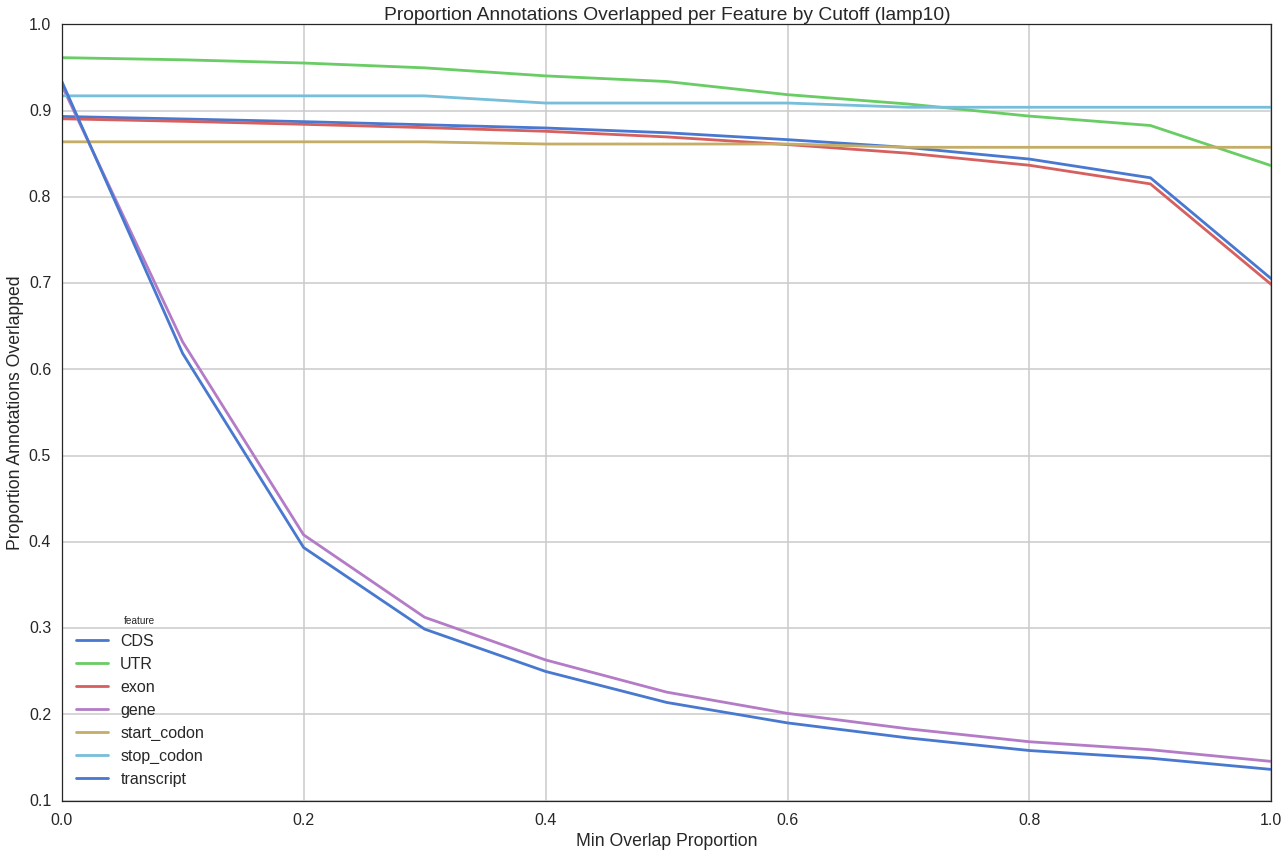

In [90]:
with sns.color_palette('muted'), FigManager() as (fig, ax):
    ann_ov_by_cutoff_df.groupby(gtf_df.feature).apply(lambda g: g.sum() / len(g)).T.plot(ax=ax)
    ax.set_ylabel('Proportion Annotations Overlapped')
    ax.set_xlabel('Min Overlap Proportion')
    ax.set_title('Proportion Annotations Overlapped per Feature by Cutoff (lamp10)')

As we might expect, the gene and transcript feature overlaps drop drastically with increasing cutoffs. Start and stop codons stay almost the same, being only 3 bases long.

#### Transcripts Overlapping Features

In [177]:
def calc_prop_transcripts_covered():
    lamp10_tr_grouped = pd.merge(aln_ann_ov_df, lamp10_pM_df, left_on='aln_id', 
             right_index=True, how='left').groupby('qseqid').count()
    lamp00_tr_grouped = pd.merge(lamp00_aln_ann_ov_df, lamp00_pM_df, left_on='aln_id', 
             right_index=True, how='left').groupby('qseqid').count()
    return len(lamp10_tr_grouped), float(len(lamp10_tr_grouped)) / resources_df.loc['lamp10']['size'], \
           len(lamp00_tr_grouped), float(len(lamp00_tr_grouped)) / resources_df.loc['petMar2_cdna']['size'], 

In [178]:
lamp10_tr_ov_num, lamp10_tr_ov_prop, lamp00_tr_ov_num, lamp00_tr_ov_prop = calc_prop_transcripts_covered()

In [179]:
results['lamp10_tr_ov_prop'] = lamp10_tr_ov_prop
results['lamp00_tr_ov_prop'] = lamp00_tr_ov_prop

In [180]:
print '{:.2f}% of lamp10 transcripts are covered >.9 by a single feature\n'\
      '{:.2f}% of lamp00 transcripts are covered >.9 by a single feature'.format(lamp10_tr_ov_prop * 100.0, 
                                                                                 lamp00_tr_ov_prop * 100.0)

29.72% of lamp10 transcripts are covered >.9 by a single feature
99.89% of lamp00 transcripts are covered >.9 by a single feature


### Subset by Homology

In [181]:
def calc_in_genome_not_annotation():
    lamp10_tr_grouped = pd.merge(aln_ann_ov_df, lamp10_pM_df, left_on='aln_id', 
        right_index=True, how='outer').groupby('qseqid').count()
    lamp00_tr_grouped = pd.merge(lamp00_aln_ann_ov_df, lamp00_pM_df, left_on='aln_id', 
        right_index=True, how='outer').groupby('qseqid').count()
    
    # Has genome hit and annotation hit
    lamp10_genome_ann = (lamp10_tr_grouped.ann_id > 0).sum()
    lamp00_genome_ann = (lamp00_tr_grouped.ann_id > 0).sum()
    
    # Has genome hit but no annotation hit
    lamp10_genome_no_ann = (lamp10_tr_grouped.ann_id == 0).sum()
    lamp00_genome_no_ann = (lamp00_tr_grouped.ann_id == 0).sum()
    
    idx = [('+genome+ann', 'lamp00'),
           ('+genome+ann', 'lamp10'),
           ('+genome-ann', 'lamp00'),
           ('+genome-ann', 'lamp10')]
    
    return pd.DataFrame([[lamp00_genome_ann, float(lamp00_genome_ann) / resources_df.loc['petMar2_cdna']['size']],
                         [lamp10_genome_ann, float(lamp10_genome_ann) / resources_df.loc['lamp10']['size']],
                         [lamp00_genome_no_ann, float(lamp00_genome_no_ann) / resources_df.loc['petMar2_cdna']['size']],
                         [lamp10_genome_no_ann, float(lamp10_genome_no_ann) / resources_df.loc['lamp10']['size']]],
                         columns=['num', 'prop'], index=pd.MultiIndex.from_tuples(idx, names=['presence', 'assembly']))

In [182]:
transcript_hom_ann_props = calc_in_genome_not_annotation()

In [183]:
results['transcript_hom_ann_props'] = transcript_hom_ann_props.reset_index().to_json(orient='split')

In [257]:
def calc_orthology_subsets():
    import itertools as it
    lamp10_tr_grouped = pd.merge(aln_ann_ov_df, lamp10_pM_df, left_on='aln_id', 
                                 right_index=True, how='outer').groupby('qseqid').count()
    lamp10_ann = lamp10_tr_grouped.ann_id == 0
    lamp10_no_ann = lamp10_tr_grouped.ann_id > 0

    filters = {
        'braflo_ortho': (lamp10_ortho['lamp10.fasta.x.braFlo.pep.all.fa.db.tsv'].evalue_x.fillna(-1) >= 0),
        'danrer_ortho': (lamp10_ortho['lamp10.fasta.x.danRer.pep.fa.db.tsv'].evalue_x.fillna(-1) >= 0),
        #'musmus_ortho': (lamp10_ortho['lamp10.fasta.x.musMus.pep.fa.db.tsv'].evalue_x.fillna(-1) >= 0),
        #'pmzrna_ortho': (lamp10_ortho['lamp10.fasta.x.petMar2.cdna.fa.db.tsv'].evalue_x.fillna(-1) >= 0)
    }
    
    perm_df = pd.DataFrame([list(p) for p in it.product([True, False], repeat=len(filters))], columns=filters.keys())

    perm_df['no_ann'] = 0
    perm_df['has_ann'] = 0
        
    for key, row in perm_df.iterrows():
        f = lamp10_ann
        for k, v in row.iteritems():
            if k in filters:
                f = f & (filters[k] == v)
        perm_df.loc[key, 'has_ann'] = f.sum()
        
        f = lamp10_no_ann
        for k, v in row.iteritems():
            if k in filters:
                f = f & (filters[k] == v)
        perm_df.loc[key, 'no_ann'] = f.sum()
    
    return perm_df

In [277]:
lamp10_danrer_braflo_ortho = calc_orthology_subsets()

In [280]:
lamp10_danrer_braflo_ortho

,danrer_ortho,braflo_ortho,no_ann,has_ann
0,True,True,3664,833
1,True,False,2450,892
2,False,True,1255,437
3,False,False,205237,309787


In [279]:
results['lamp10_danrer_braflo_ortho'] = lamp10_danrer_braflo_ortho.to_json(orient='split')

In [261]:
def calc_homology_subsets():
    import itertools as it
    lamp10_tr_grouped = pd.merge(aln_ann_ov_df, lamp10_pM_df, left_on='aln_id', 
                                 right_index=True, how='outer').groupby('qseqid').count()
    lamp10_ann = lamp10_tr_grouped.ann_id == 0
    lamp10_no_ann = lamp10_tr_grouped.ann_id > 0

    filters = {
        'braflo_best_hom': (lamp10_best_hits['lamp10.fasta.x.braFlo.pep.all.fa.db.tsv'].evalue.fillna(-1) >= 0),
        'danrer_best_hom': (lamp10_best_hits['lamp10.fasta.x.danRer.pep.fa.db.tsv'].evalue.fillna(-1) >= 0),
        #'musmus_ortho': (lamp10_ortho['lamp10.fasta.x.musMus.pep.fa.db.tsv'].evalue_x.fillna(-1) >= 0),
        #'pmzrna_ortho': (lamp10_ortho['lamp10.fasta.x.petMar2.cdna.fa.db.tsv'].evalue_x.fillna(-1) >= 0)
    }
    
    perm_df = pd.DataFrame([list(p) for p in it.product([True, False], repeat=len(filters))], columns=filters.keys())

    perm_df['no_ann'] = 0
    perm_df['has_ann'] = 0
        
    for key, row in perm_df.iterrows():
        f = lamp10_ann
        for k, v in row.iteritems():
            if k in filters:
                f = f & (filters[k] == v)
        perm_df.loc[key, 'has_ann'] = f.sum()
        
        f = lamp10_no_ann
        for k, v in row.iteritems():
            if k in filters:
                f = f & (filters[k] == v)
        perm_df.loc[key, 'no_ann'] = f.sum()
    
    return perm_df

In [281]:
lamp10_danrer_braflo_homs = calc_homology_subsets()

In [282]:
lamp10_danrer_braflo_homs

,braflo_best_hom,danrer_best_hom,no_ann,has_ann
0,True,True,36605,10293
1,True,False,847,873
2,False,True,7196,4445
3,False,False,167958,296338


In [286]:
results['lamp10_danrer_braflo_homs'] = lamp10_danrer_braflo_homs.to_json(orient='split')

In [287]:
dump_results()

### Describe Overlaps

In [320]:
store.close()

In [312]:
(lamp10_ortho['lamp10.fasta.x.petMar2.cdna.fa.db.tsv'].fillna(-1).evalue_x > 0).sum()

1544

In [318]:
store['lamp10.fasta.x.petMar2.cdna.fa.db.tsv'].fillna(-1).groupby('sseqid').count()

,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,sstrand,qstrand
sseqid,,,,,,,,,,,,
ENSPMAT00000000001,1,1,1,1,1,1,1,1,1,1,1,1
ENSPMAT00000000002,9,9,9,9,9,9,9,9,9,9,9,9
ENSPMAT00000000003,20,20,20,20,20,20,20,20,20,20,20,20
ENSPMAT00000000004,5,5,5,5,5,5,5,5,5,5,5,5
ENSPMAT00000000005,23,23,23,23,23,23,23,23,23,23,23,23
ENSPMAT00000000006,32,32,32,32,32,32,32,32,32,32,32,32
ENSPMAT00000000007,18,18,18,18,18,18,18,18,18,18,18,18
ENSPMAT00000000008,13,13,13,13,13,13,13,13,13,13,13,13
ENSPMAT00000000009,14,14,14,14,14,14,14,14,14,14,14,14


In [319]:
resources_df.loc['petMar2_cdna']

access                                             remote_file
condition                                                  NaN
db_type                                                   nucl
filename                                       petMar2.cdna.fa
flowcell                                                   NaN
label                                                      NaN
meta_type                                       fasta_database
paired                                                     NaN
phred                                                      NaN
q_type                                                     NaN
strand                                                     NaN
terms                                                      NaN
tissue                                                     NaN
url          ftp://ftp.ensembl.org/pub/release-75/fasta/pet...
size                                                     11489
Name: petMar2_cdna, dtype: object

In [291]:
lamp00_10_all_ov_df = pd.DataFrame(lamp10_aln_subj_forest.intersect(lamp00_aln_subj_forest, self_cutoff=0.0, other_cutoff=0.0), 
                             columns=['lamp10_id', 'lamp00_id', 'ov_len'])
lamp00_10_all_ov_df.sort(columns='lamp10_id', inplace=True)

In [294]:
lamp_aln_matches = pd.DataFrame(lamp10_aln_subj_forest.intersect(lamp00_aln_subj_forest, self_cutoff=0.9, other_cutoff=0.9), 
                             columns=['lamp10_id', 'lamp00_id', 'ov_len'])

In [304]:
lamp00_pM_df.loc[ lamp_aln_matches.sort(columns='lamp10_id').set_index('lamp10_id').loc[2641].lamp00_id ]

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,sstrand,qstrand
aln_id,,,,,,,,,,,,,,
133011,ENSPMAT00000004445,GL477236,84.09,176,26,2,257,432,281756,281931,5.000000e-40,169,-1,1
200659,ENSPMAT00000001237,GL477236,78.57,224,48,0,197,421,281758,281982,6.000000e-34,148,-1,1
85210,ENSPMAT00000000738,GL477236,82.68,179,31,0,235,414,281759,281938,3.000000e-37,159,-1,1
140451,ENSPMAT00000003935,GL477236,85.96,178,25,0,232,410,281760,281938,9.000000e-47,191,-1,1
122325,ENSPMAT00000004932,GL477236,83.33,198,33,0,240,438,281762,281960,2.000000e-44,183,-1,1
58743,ENSPMAT00000010033,GL477236,85.06,154,23,0,248,402,281777,281931,1.000000e-36,158,-1,1
90377,ENSPMAT00000007341,GL477236,86.36,154,21,0,254,408,281777,281931,5.000000e-40,169,-1,1
194825,ENSPMAT00000000317,GL477236,100.00,235,0,0,11,246,281756,281991,2.000000e-120,435,-1,1
35407,ENSPMAT00000008754,GL477236,87.29,181,23,0,260,441,281750,281931,1.000000e-51,207,-1,1


,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,sstrand,qstrand
aln_id,,,,,,,,,,,,,,
0,c534414_g1_i1,GL477458,99.44,179,1,0,14,193,59695,59874,1.000000e-87,326.0,-1,1
1,c534508_g1_i1,GL487923,100.00,214,0,0,0,214,7825,8039,8.000000e-109,396.0,-1,1
2,c534069_g1_i1,GL476614,99.52,210,1,0,0,210,444049,444259,7.000000e-105,383.0,1,1
3,c534741_g1_i1,GL482427,99.51,203,1,0,0,203,5542,5745,5.000000e-101,370.0,-1,1
4,c534445_g1_i1,GL478305,99.58,239,1,0,0,239,15029,15268,6.000000e-121,436.0,-1,1
5,c533911_g1_i1,GL476654,100.00,76,0,0,0,76,233523,233599,4.000000e-32,141.0,1,1
6,c534213_g1_i1,GL476534,100.00,199,0,0,0,199,884270,884469,2.000000e-100,368.0,-1,1
7,c534470_g1_i1,GL476360,99.77,439,1,0,0,439,213591,214030,0.000000e+00,806.0,1,1
8,c534474_g1_i1,GL476949,98.05,256,5,0,14,270,85993,86249,1.000000e-123,446.0,-1,1


In [308]:
len(lamp10_db['c221072_g1_i1'].sequence)

203

### Describe Overlaps

Retrieve the indices of each overlapping transcript for each feature

Join the metadata from the features and corresponding overlapped alignments

In [32]:
overlap_df = gtf_df.join(overlap_data).join(lamp10_pM_df).sortlevel()

In [33]:
overlap_df['ann_length'] = overlap_df.end - overlap_df.start
overlap_df['aln_overlap_prop'] = overlap_df.overlap_len / overlap_df.length
overlap_df['ann_overlap_prop'] = overlap_df.overlap_len / overlap_df.ann_length

In [34]:
overlap_df.head()

contig_id          source feature   start     end score strand  \
ann_id aln_id                                                                  
5124   616481  GL476328  protein_coding    gene  168846  169476     .      +   
       616484  GL476328  protein_coding    gene  168846  169476     .      +   
       616490  GL476328  protein_coding    gene  168846  169476     .      +   
       616493  GL476328  protein_coding    gene  168846  169476     .      +   
       616497  GL476328  protein_coding    gene  168846  169476     .      +   

              frame exon_id exon_number       ...         qend  sstart  \
ann_id aln_id                                 ...                        
5124   616481     .     NaN         NaN       ...         1783  169341   
       616484     .     NaN         NaN       ...         2070  169341   
       616490     .     NaN         NaN       ...          763  169341   
       616493     .     NaN         NaN       ...         2557  169341   
       616497     .     NaN         NaN       ...         1260  169341   

                 send evalue bitscore qstrand sstrand ann_length  \
ann_id aln_id                                                      
5124   616481  169723      0      652       +       -        630   
       616484  169723      0      652       +       -        630   
       616490  169723      0      652       +       -        630   
       616493  169723      0      652       +       -        630   
       616497  169723      0      652       +       -        630   

               aln_overlap_prop ann_overlap_prop  
ann_id aln_id                                     
5124   616481          0.350649         0.214286  
       616484          0.350649         0.214286  
       616490          0.350649         0.214286  
       616493          0.350649         0.214286  
       616497          0.350649         0.214286  

[5 rows x 36 columns]

#### How many transcripts overlap a feature at all?

In [35]:
tr_intersecting = (overlap_df.reset_index().groupby('qseqid')['ann_id'].count() > 0).sum()
tr_total = len(tpm_df)
print '{} of {} transcripts overlap a GTF feature ({:.2f})'.format(tr_intersecting, tr_total, 
                                                                   float(tr_intersecting) / tr_total)

218160 of 715345 transcripts overlap a GTF feature (0.30)


#### How big are the overlaps?

We can easily examine the proportion of a given sequence overlapped, be it a transcript (ie, how much of the transcript was overlapped by the specific feature) or an annotation. We can also subset the annotations by feature type.

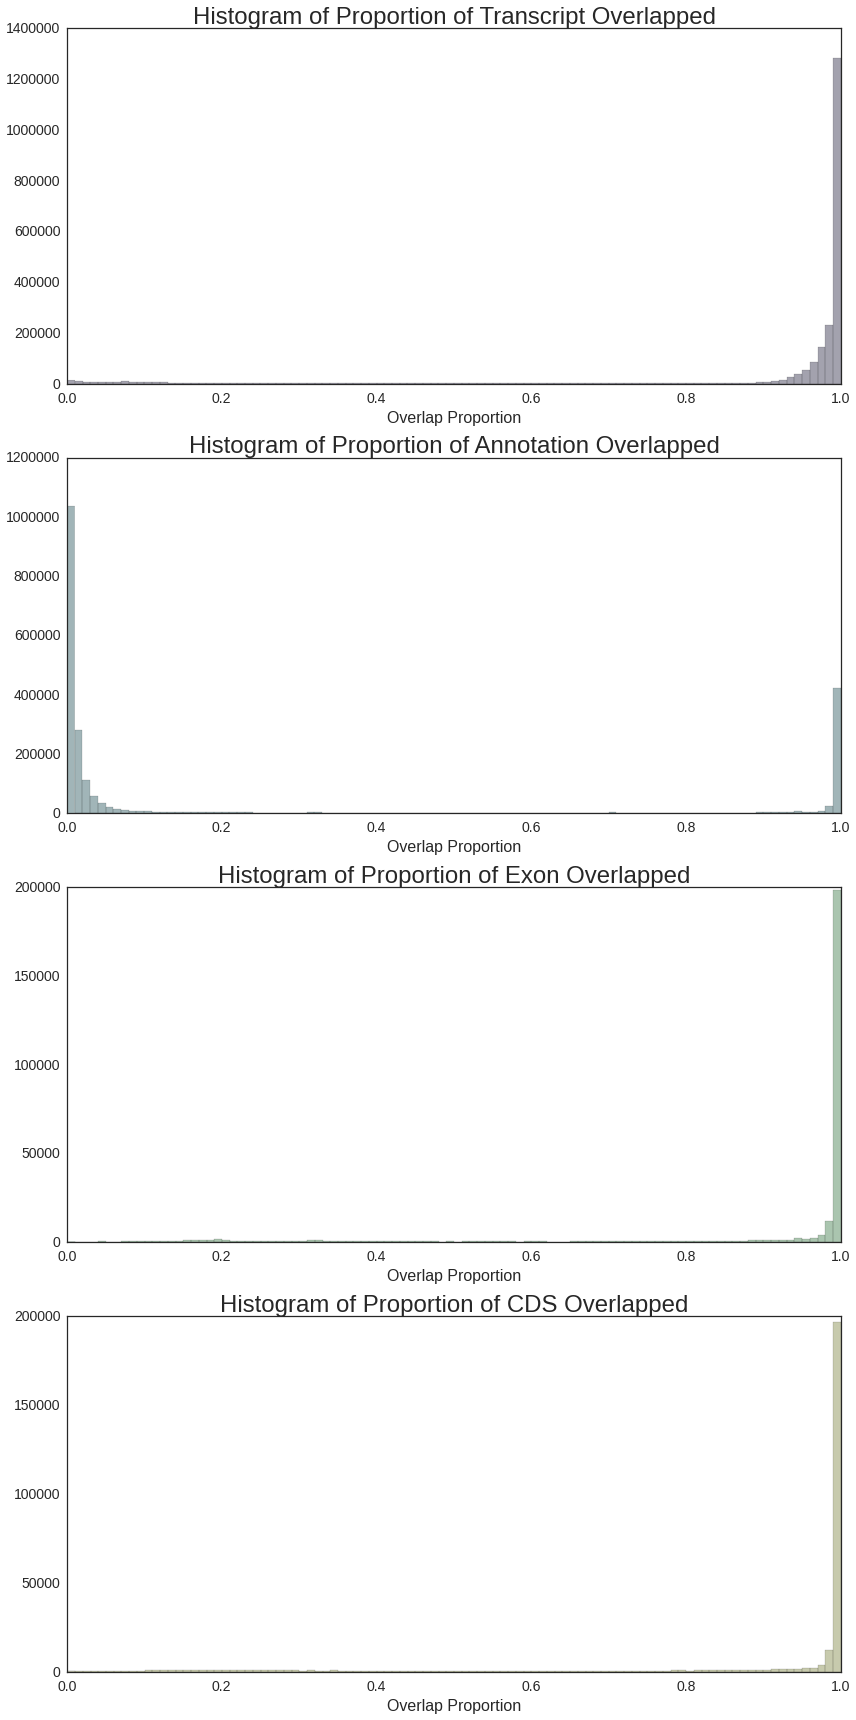

In [36]:
with FigManager(nrows=4, figsize=(12,24)) as (fig, ax):
    colors = sns.color_palette("cubehelix", 8)
    sns.distplot(overlap_df.aln_overlap_prop.dropna(), ax=ax[0], kde=False, bins=100, color=colors[0],
                 axlabel='Overlap Proportion')
    ax[0].set_title('Histogram of Proportion of Transcript Overlapped')
    
    sns.distplot(overlap_df.ann_overlap_prop.dropna(), ax=ax[1], kde=False, bins=100, color=colors[1], 
                 axlabel='Overlap Proportion')
    ax[1].set_title('Histogram of Proportion of Annotation Overlapped')
 
    sns.distplot(overlap_df[overlap_df.feature == 'exon'].ann_overlap_prop.dropna(), ax=ax[2], color=colors[2],
                 kde=False, bins=100, axlabel='Overlap Proportion')
    ax[2].set_title('Histogram of Proportion of Exon Overlapped')

    sns.distplot(overlap_df[overlap_df.feature == 'CDS'].ann_overlap_prop.dropna(), ax=ax[3], color=colors[3],
                 kde=False, bins=100, axlabel='Overlap Proportion')
    ax[3].set_title('Histogram of Proportion of CDS Overlapped')

### WIP: Abundance + cross validation

In [119]:
tpm_df['ann_id'] = False
tpm_df.update((gtf_aln_df.reset_index().groupby('qseqid')['ann_id'].count() > 0))
tpm_df.rename(columns={'ann_id':'has_annotation'}, inplace=True)

In [121]:
tpm_df['mean_tpm'] = tpm_df.drop('has_annotation', axis=1).mean(axis=1)

In [165]:
tpm_df[tpm_df.has_annotation == True].mean_tpm.median()

0.7561955235359132

In [166]:
tpm_df[tpm_df.has_annotation == False].mean_tpm.median()

0.7595900362358685

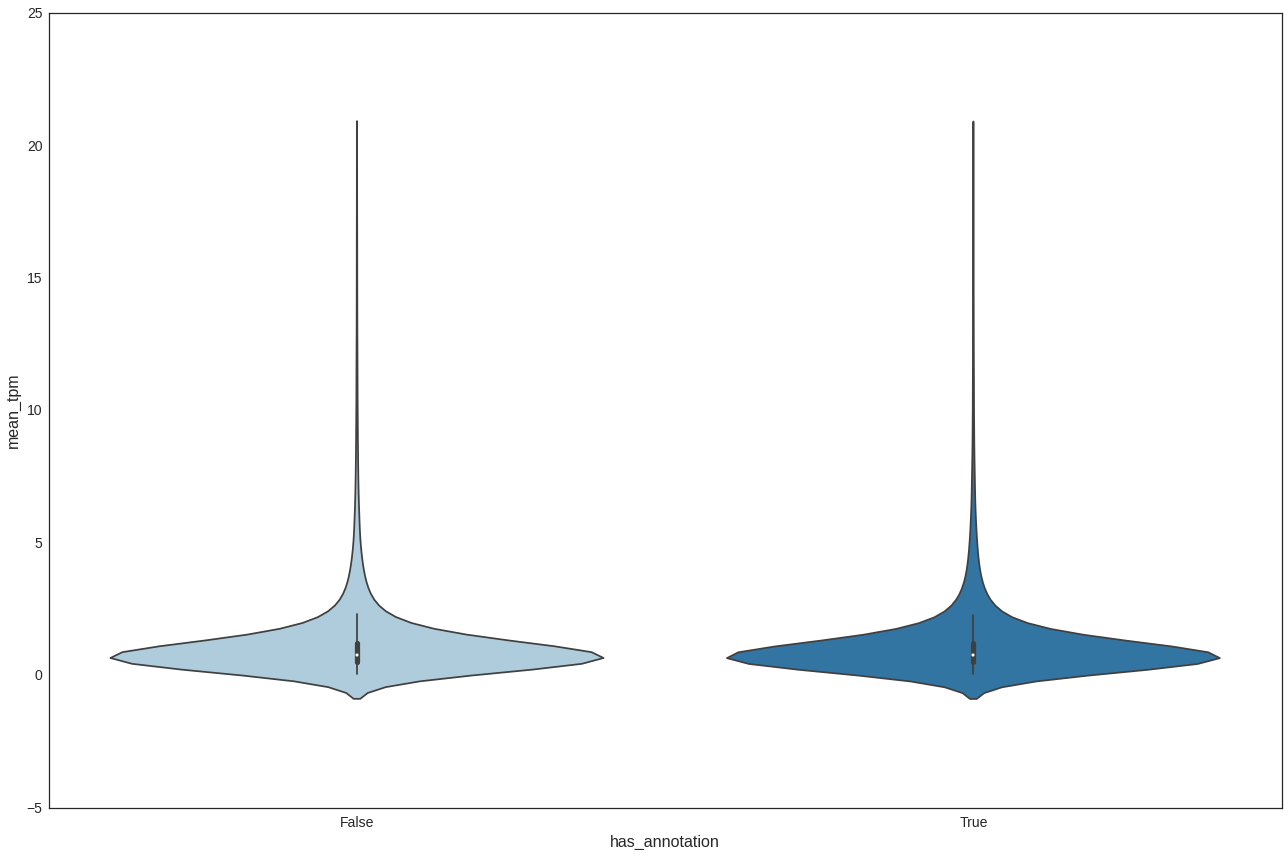

In [164]:
with FigManager() as (fig, ax):
    sns.violinplot(x='has_annotation', y='mean_tpm', data=tpm_df[tpm_df.mean_tpm < 20], ax=ax, bw=.3)

In [233]:
store.close()

### Deprecated

### Utility Functions

Given a genome contig and a range, get the appropriate interval tree and find overlapping intervals. Return the DataFrame indices for matching features.

In [24]:
def describe_overlap(qstart, qend, istart, iend, delta=2):
    qlen = qend - qstart
    ilen = iend - istart
    
    if qstart == istart and qend == iend:
        return 'exact', qlen, 1.0
    
    elif qstart >= istart:
        if qend <= iend:
            return 'contained', qlen, 1.0
        else:
            olen = iend - qstart
            return 'overlaps', olen, float(olen) / qlen
    else:
        if qend <= iend:
            olen = qend - istart
            return 'overlaps', olen, float(olen) /qlen
        else:
            return 'contains', ilen, 1.0

In [25]:
# Tests!
assert describe_overlap(5,10,0,15) == ('contained', 5, 1.0)
assert describe_overlap(0,15,5,10) == ('contains', 5, 1.0)
assert describe_overlap(0,10,5,15) == ('overlaps', 5, .5)
assert describe_overlap(5,15,0,10) == ('overlaps', 5, .5)
assert describe_overlap(0,10,0,10) == ('exact', 10, 1.0)

In [26]:
def get_overlap_rows(seqname, start, end, db, overlaps):
    try:
        tree = db[seqname]
    except Exception as e:
        #print >>sys.stderr, 'No interval tree for sequence', seqname, e
        return []
    # Turns out the intervaltree requires (min,max) style coordinates
    rows = []
    for interval in tree[min(start,end):max(start,end)]:
        ix, feature = interval.data
        rows.append(ix)
        overlaps.append(describe_overlap(min(start, end), max(start, end), interval.begin, interval.end) + (feature, ))
        
    return rows

In [27]:
def get_overlaps(df, db, block_size=5000):
    bar = pyprind.ProgBar(len(df) / block_size, stream=1)
    
    df['features'] = None
    overlaps = []
    for block_start in range(0,len(df), block_size):
        bar.update()
        df.ix[block_start:block_start+block_size, 'features'] = \
            df.ix[block_start:block_start+block_size].apply(
            lambda row: get_overlap_rows(row.sseqid, row.sstart, row.send, db, overlaps), axis=1)
    
    odf = pd.DataFrame(overlaps, columns=['overlap_type', 'length', 'percent', 'feature'])
    return odf

In [28]:
def quantify_overlaps(df, gtf_df=gtf_df):
    df['tr'] = df.index
    df.sort(columns=['tr', 'sseqid'], inplace=True)
    
    overlapped_rows = set()
    df.apply(lambda row: overlapped_rows.update(row.features), axis=1)
    
    stats_srs = gtf_df.ix[list(overlapped_rows)].groupby(by='feature').count().source / \
               gtf_df.groupby(by='feature', axis=0).count().source
    stats_srs = stats_srs.append(pd.Series(float(len(overlapped_rows)) / len(gtf_df), index=['all']))
    
    for feature, perc in stats_srs.iteritems():
        print '{:.2f}% of {:s} features overlapped'.format(perc * 100.0, feature)
    return stats_srs

In [35]:
lamp00_overlaps = get_overlaps(lamp00_pM_df, petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 16.920 sec


In [36]:
lamp00_stats_srs = quantify_overlaps(lamp00_pM_df)

91.98% of CDS features overlapped
96.27% of UTR features overlapped
89.69% of exon features overlapped
79.88% of gene features overlapped
95.00% of start_codon features overlapped
98.04% of stop_codon features overlapped
81.35% of transcript features overlapped
89.93% of all features overlapped


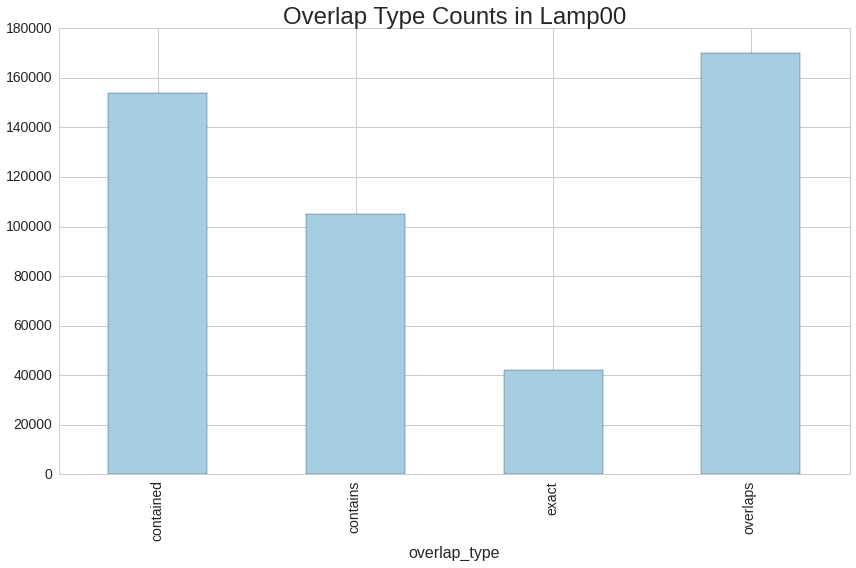

/home/camille/w/2015-petMarSB/notebooks/lamp00_overlap_type_counts.svg

In [44]:
with FigManager('lamp00_overlap_type_counts', figsize=norm_size, show=True) as (fig, ax):
    lamp00_overlaps[lamp00_overlaps.feature.isin(['exon', 'CDS', 'gene'])].\
        groupby('overlap_type').count().length.plot(kind='bar', fig=fig, ax=ax)
    ax.set_title('Overlap Type Counts in Lamp00')
FileLink('lamp00_overlap_type_counts.svg')

Looks alright; now for our assembly.

In [38]:
lamp10_overlaps = get_overlaps(lamp10_pM_df, petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 250.054 sec


In [39]:
lamp10_stats_srs = quantify_overlaps(lamp10_pM_df)

89.22% of CDS features overlapped
95.55% of UTR features overlapped
88.95% of exon features overlapped
92.96% of gene features overlapped
85.05% of start_codon features overlapped
90.81% of stop_codon features overlapped
93.42% of transcript features overlapped
89.60% of all features overlapped


In [ ]:
lamp10_pM_df['features'] = None
lamp10_hom_overlaps = get_overlaps(lamp10_pM_df[blast_df.musMus_pep & blast_df.homSap_pep & blast_df.danRer_pep], petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 99.686 sec


In [ ]:
lamp10_hom_stats_srs = quantify_overlaps(lamp10_pM_df)

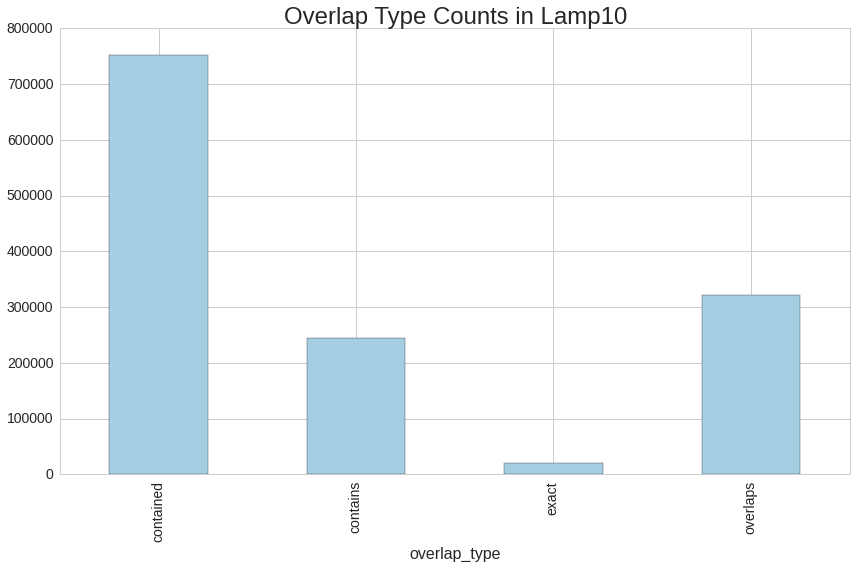

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_type_counts.svg

In [45]:
with FigManager('lamp10_overlap_type_counts', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[lamp10_overlaps.feature.isin(['exon', 'CDS', 'gene'])].\
        groupby('overlap_type').count().length.plot(kind='bar', fig=fig, ax=ax)
    ax.set_title('Overlap Type Counts in Lamp10')
FileLink('lamp10_overlap_type_counts.svg')

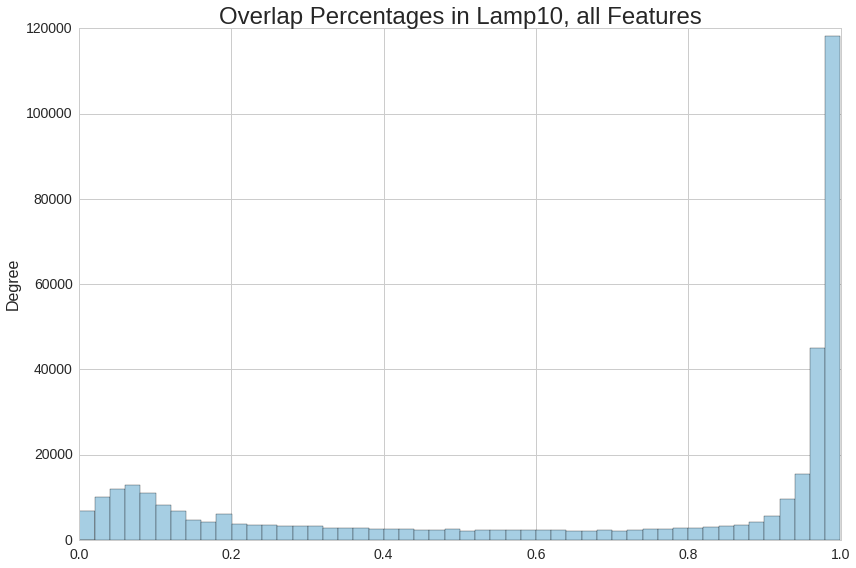

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_percentages_all.svg

In [46]:
with FigManager('lamp10_overlap_percentages_all', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[lamp10_overlaps.overlap_type == 'overlaps'].percent.plot(kind='hist', fig=fig, ax=ax, bins=50)
    ax.set_title('Overlap Percentages in Lamp10, all Features')
FileLink('lamp10_overlap_percentages_all.svg')

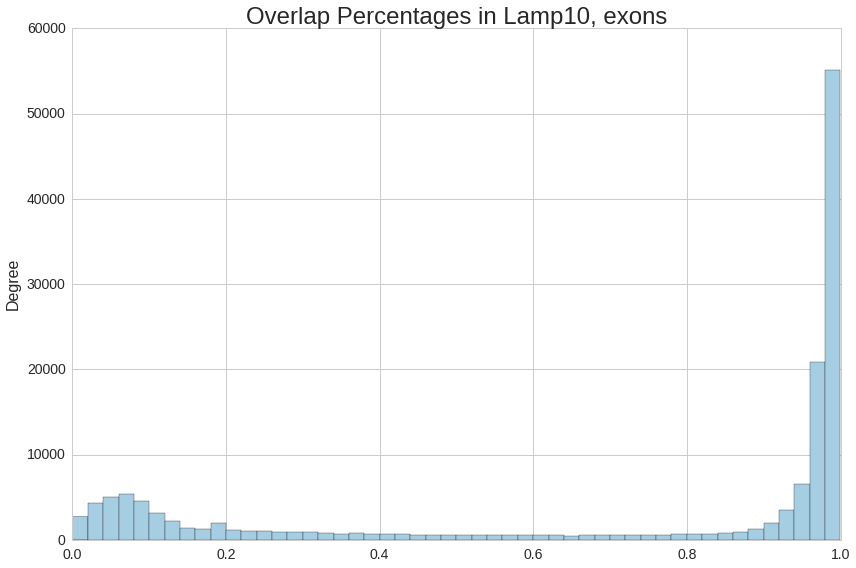

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_percentages_exons.svg

In [47]:
with FigManager('lamp10_overlap_percentages_exons', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[(lamp10_overlaps.overlap_type == 'overlaps') & \
                    (lamp10_overlaps.feature == 'exon')].percent.plot(kind='hist', 
                                                                                             fig=fig, ax=ax, bins=50)
    ax.set_title('Overlap Percentages in Lamp10, exons')
FileLink('lamp10_overlap_percentages_exons.svg')

TODO
1. Normalize vs. amount of genome covered by features
2. Use lamp00 as control for this method X
3. Pull out overlapped for more comparison X
4. Do again with only transcripts mapping to genome + other and do same process
5. Graph align old dna, new dna; transcripts
6. CEGMA 

In [150]:
store.close()